In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
from keras import Sequential
from tensorflow.keras import layers
import glob

In [2]:
import random
SORT_IMAGES = False
data_dir = './data/QualityControlTraining'
images = glob.glob(data_dir + '/ACCEPT/*')
extensions = ['/ACCEPT', '/REJECT', '/REWORK']
img = PIL.Image.open(images[0])
if SORT_IMAGES:
  for extension in extensions:
    image_paths = glob.glob(data_dir + extension + '/*.jpg')
    for path in image_paths:
      img = PIL.Image.open(path)
      cropped = img.crop((1000, 0, 1500, img.size[1]))
      if random.randint(0, 4) == 0:
        file_name = img.filename.replace(extension, "/TEST")
        file_name = file_name.replace('QualityControlTraining', 'QualityControlCropped')
        cropped.save(file_name)
      else:
        cropped.save(img.filename.replace('QualityControlTraining', 'QualityControlCropped'))


In [3]:
img = PIL.Image.open(images[0])
print(img.size)
cropped = img.crop((1000, 0, 1500, 2048))
cropped.size

(2448, 2048)


(500, 2048)

In [4]:
batch_size = 16
img_height = int(2048 / 8)
img_width = int(600 / 8)

data_dir = './data/QualityControlCropped'
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2806 files belonging to 3 classes.
Using 2245 files for training.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2806 files belonging to 3 classes.
Using 561 files for validation.


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [7]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(3),
  layers.Dropout(0.5)
])


In [8]:
from keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 75, 3)        0         
                                                                 
 conv2d (Conv2D)             (None, 256, 75, 16)       448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 37, 16)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 37, 32)       4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 18, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 18, 64)        1

In [10]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/50
141/141 [==============================] - 30s 153ms/step - loss: 0.9300 - accuracy: 0.5024 - val_loss: 0.7850 - val_accuracy: 0.5508
Epoch 2/50
141/141 [==============================] - 27s 194ms/step - loss: 0.7992 - accuracy: 0.5768 - val_loss: 0.6673 - val_accuracy: 0.6417
Epoch 3/50
141/141 [==============================] - 36s 258ms/step - loss: 0.7287 - accuracy: 0.6245 - val_loss: 0.5510 - val_accuracy: 0.7326
Epoch 4/50
141/141 [==============================] - 26s 181ms/step - loss: 0.6947 - accuracy: 0.6512 - val_loss: 0.5089 - val_accuracy: 0.7629
Epoch 5/50
141/141 [==============================] - 33s 234ms/step - loss: 0.7024 - accuracy: 0.6432 - val_loss: 0.4782 - val_accuracy: 0.7897
Epoch 6/50
141/141 [==============================] - 36s 256ms/step - loss: 0.6682 - accuracy: 0.6552 - val_loss: 0.5541 - val_accuracy: 0.6988
Epoch 7/50
141/141 [==============================] - 24s 170ms/step - loss: 0.6653 - accuracy: 0.6557 - val_loss: 0.5424 - val_ac

In [11]:
model.save('./models')


INFO:tensorflow:Assets written to: ./models\assets


INFO:tensorflow:Assets written to: ./models\assets


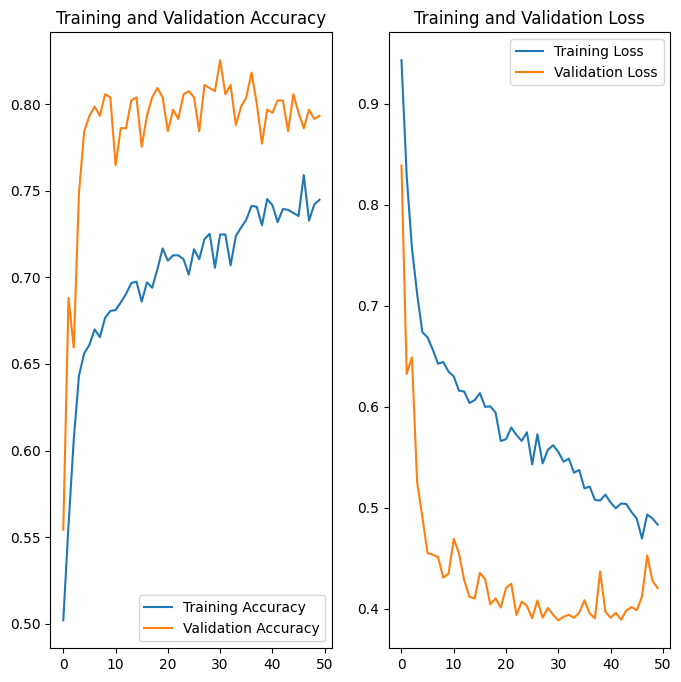

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [23]:
images = glob.glob(data_dir + '/TEST/*')

In [25]:
import keras.utils as image

images = glob.glob(data_dir + '/TEST/*')
class_names = ['ACCEPT', 'REJECT', 'REWORK']
TEST_FILEPATH = './data/TEST'

correct = {}
count = {}
total_count = 0

misclassified = {}

for _class in class_names:
  correct[_class] = 0
  count[_class] = 0
  misclassified[_class] = []

for filename in os.listdir(TEST_FILEPATH):
  classification = filename.split('-')[0]
  image_path = os.path.join(TEST_FILEPATH, filename)
  img = image.load_img(image_path, target_size=(img_height, img_width))
  
  img_array = image.img_to_array(img)
  img_array = tf.expand_dims(img_array, axis=0)
  
  prediction = model.predict(img_array)
  predicted_class = np.argmax(prediction[0])
  confidence_distribution = tf.nn.softmax(prediction[0]).numpy()
  class_name = class_names[predicted_class]
  
  count[classification] += 1
  if class_name == classification:
    correct[classification] += 1
  else:  
    misclassified[classification].append((image_path, class_name, confidence_distribution))
      
      
for _class in class_names:
  print(f"ACCURACY FOR {_class}: {correct[_class] / count[_class]}")
    
  
  

1/1 [==============================] - 0s 32ms/step
ACCURACY FOR ACCEPT: 0.8767123287671232
ACCURACY FOR REJECT: 1.0
ACCURACY FOR REWORK: 0.717948717948718


In [111]:
  for _class in class_names:
    print(f"COUNT FOR {_class}: {count[_class]}")

COUNT FOR ACCEPT: 292
COUNT FOR REJECT: 89
COUNT FOR REWORK: 273


In [126]:
from PIL import Image 
def graph_images(_class, misclassified_dict): 
  for (path, misclassification, distribution) in misclassified_dict[_class]:
    img = PIL.Image.open(path)
    img = img.convert('RGB')
    img_array = np.array(img)
    plt.title(f"{_class} : {misclassification} : A: {distribution[0]:.0%} : Rej: {distribution[1]:.0%} : Rew {distribution[2]:.0%}, {path}")
  
    plt.imshow(img_array, cmap="viridis")
    plt.axis('off')
    plt.show()

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x2048 at 0x2868D2E3F08>


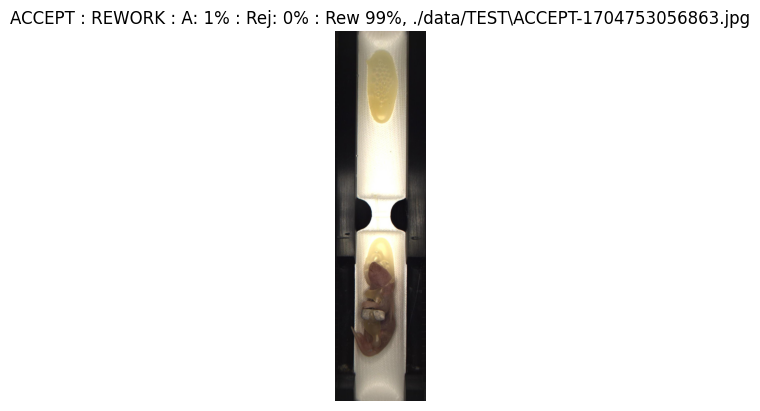

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x2048 at 0x28681024CC8>


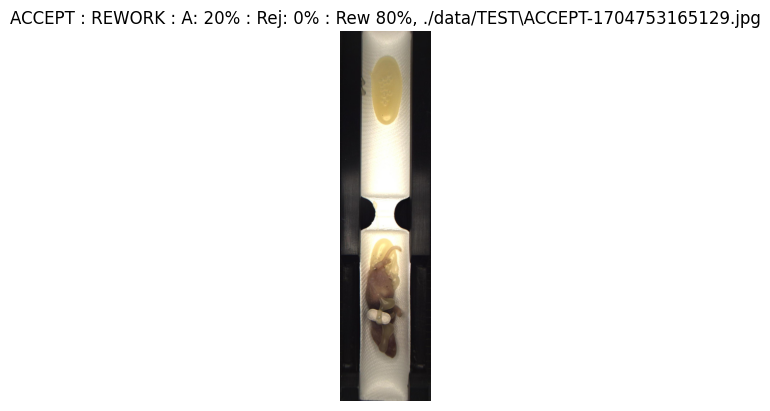

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x2048 at 0x2868D2EBA88>


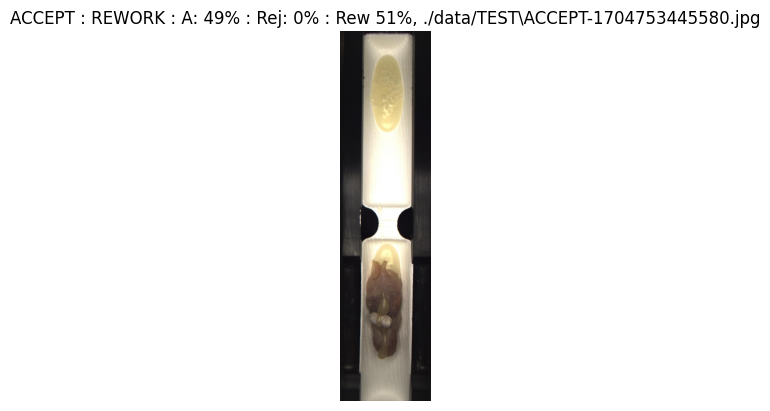

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x2048 at 0x2868BF39508>


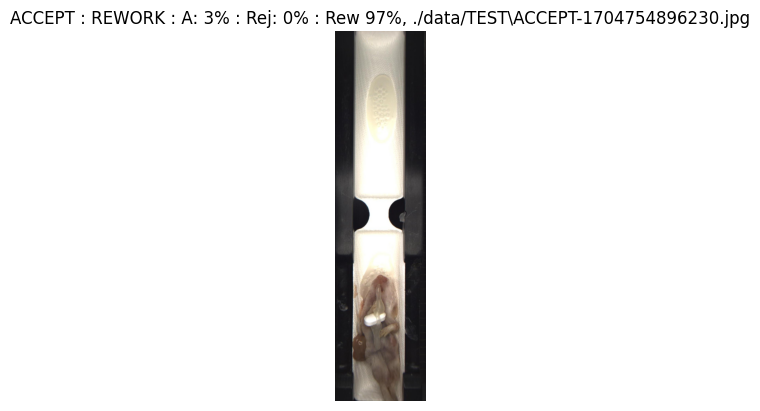

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x2048 at 0x2868D2D8088>


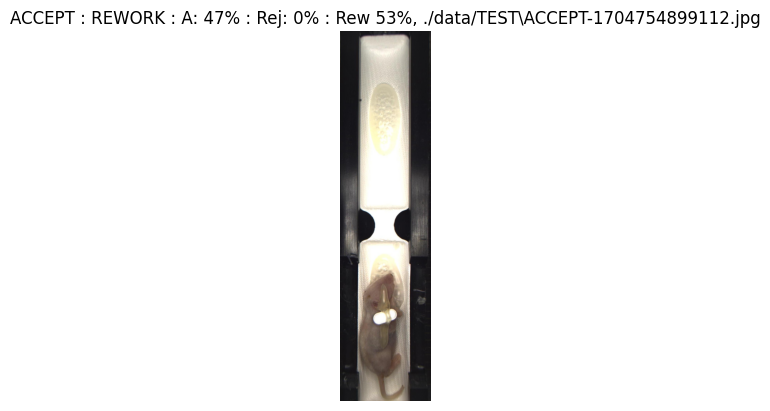

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x2048 at 0x28681027B88>


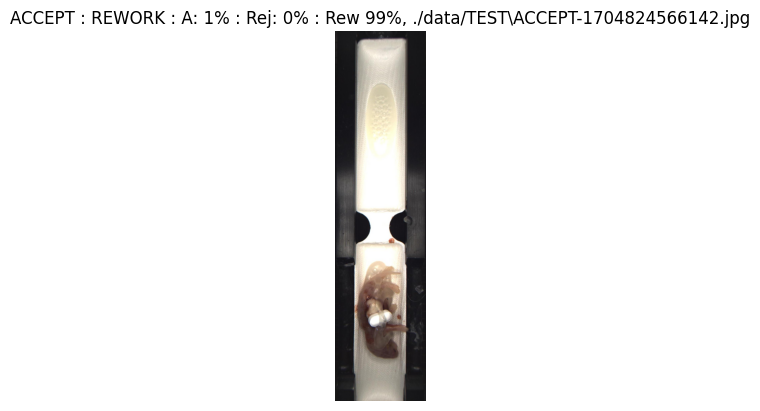

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x2048 at 0x28687F7D288>


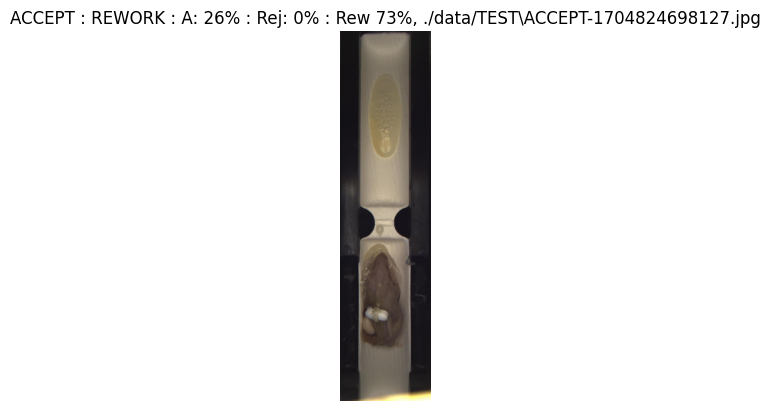

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x2048 at 0x28689919848>


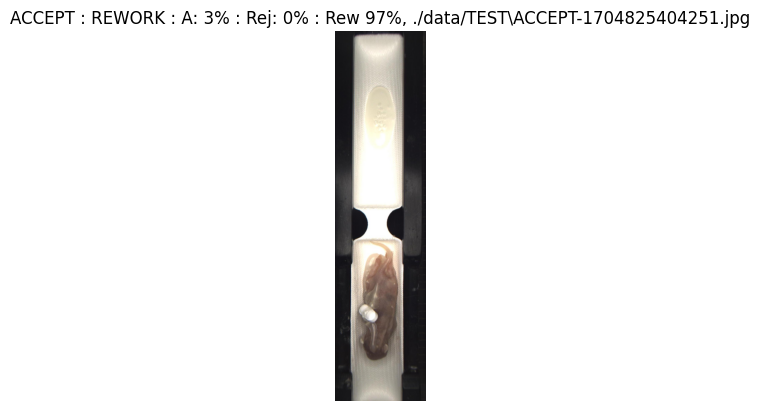

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x2048 at 0x28689E15D88>


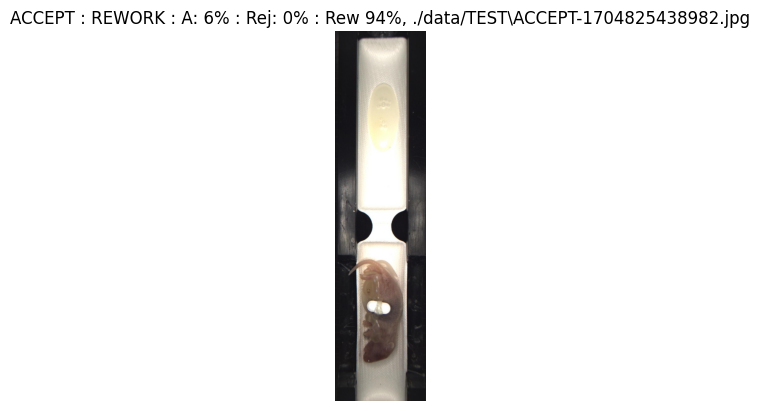

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x2048 at 0x28681364A08>


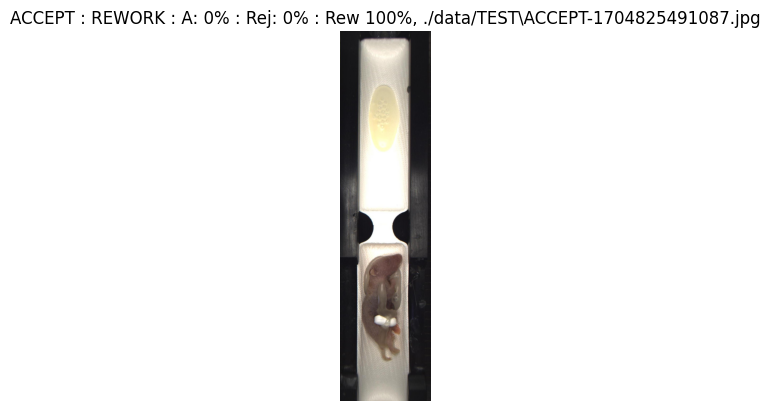

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x2048 at 0x286811ADE88>


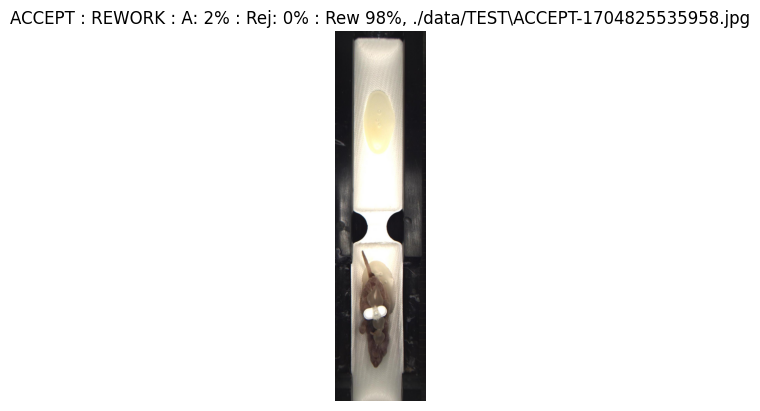

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x2048 at 0x28687FF6048>


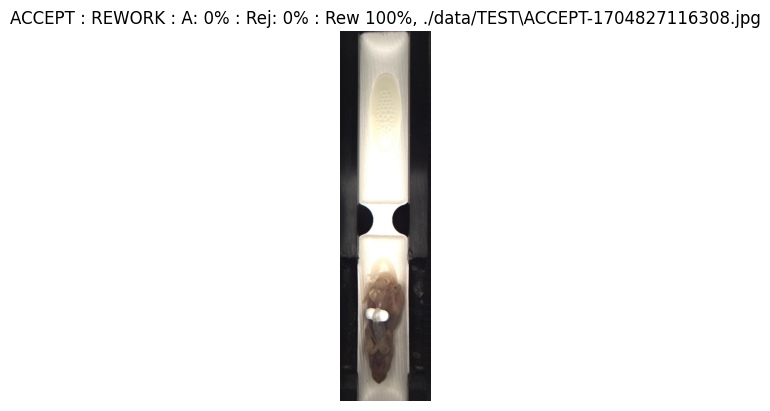

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x2048 at 0x28689E76348>


KeyboardInterrupt: 

In [127]:
graph_images("ACCEPT", misclassified)

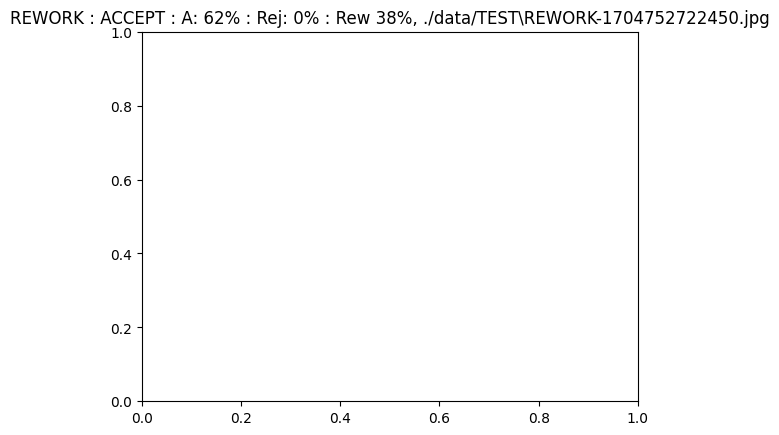

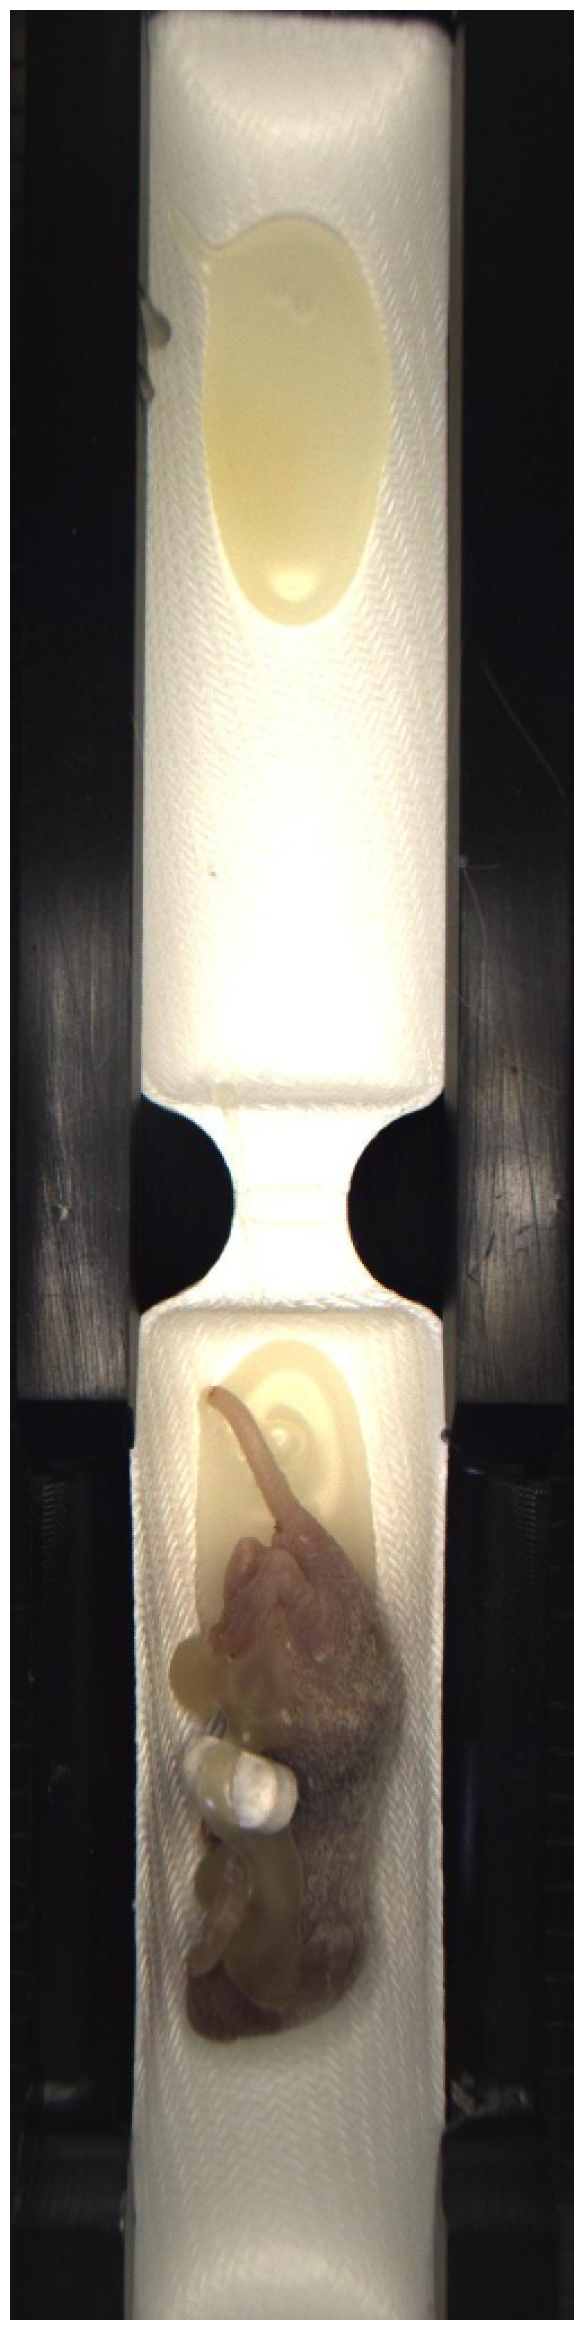

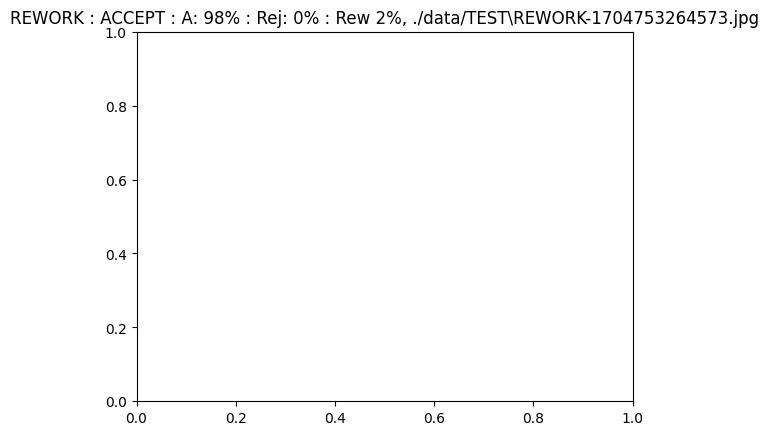

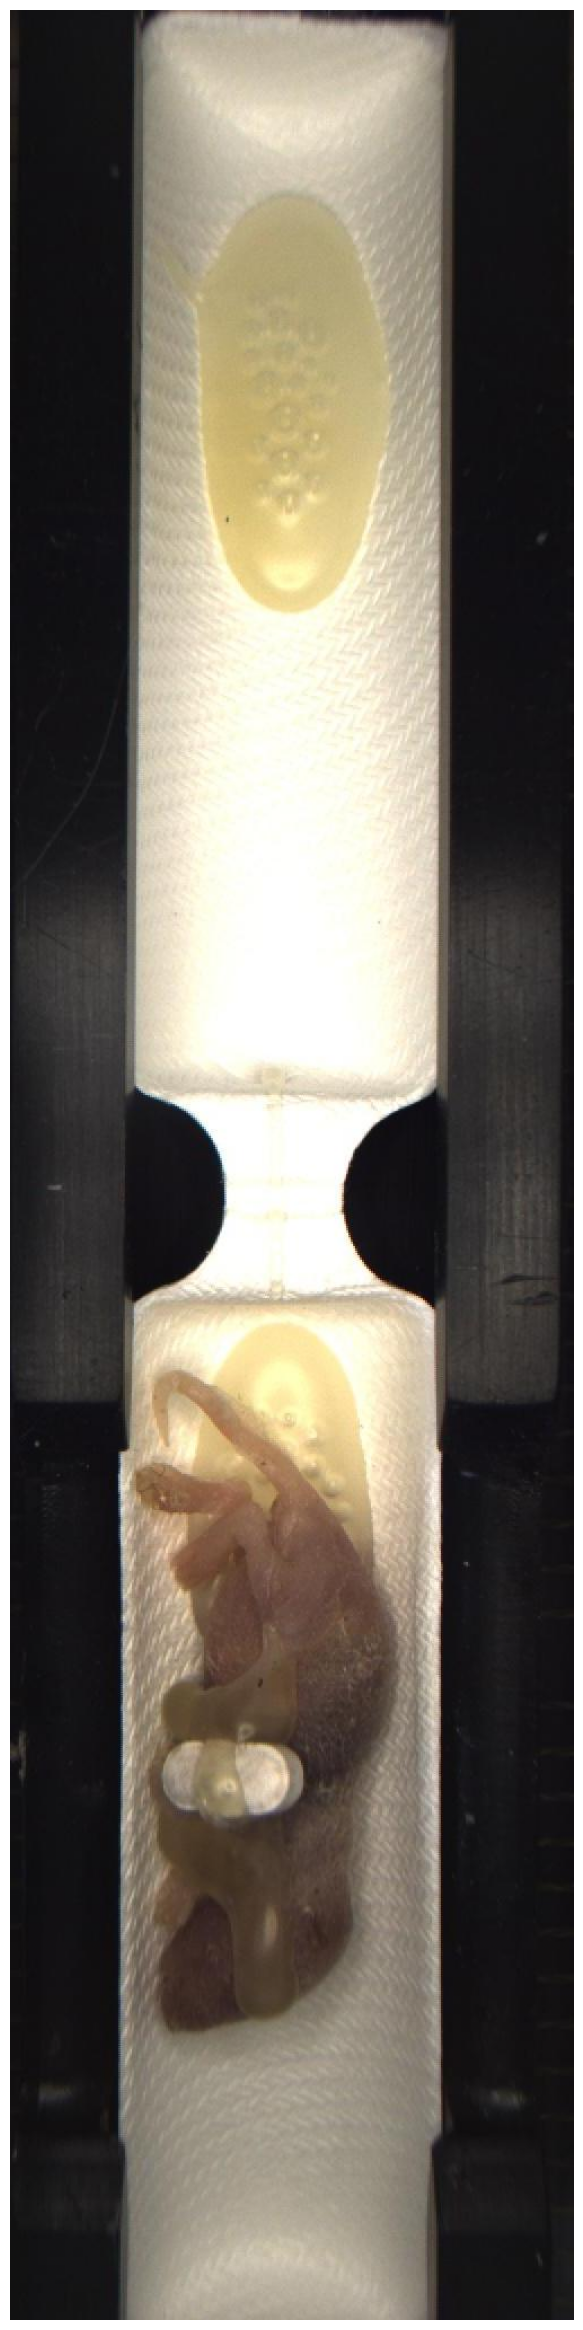

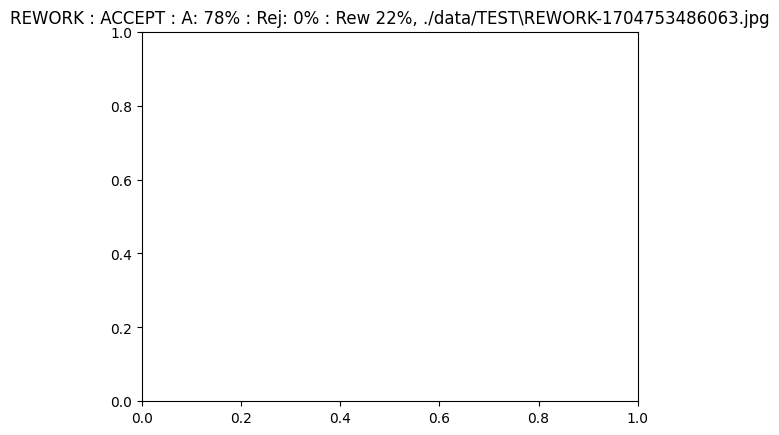

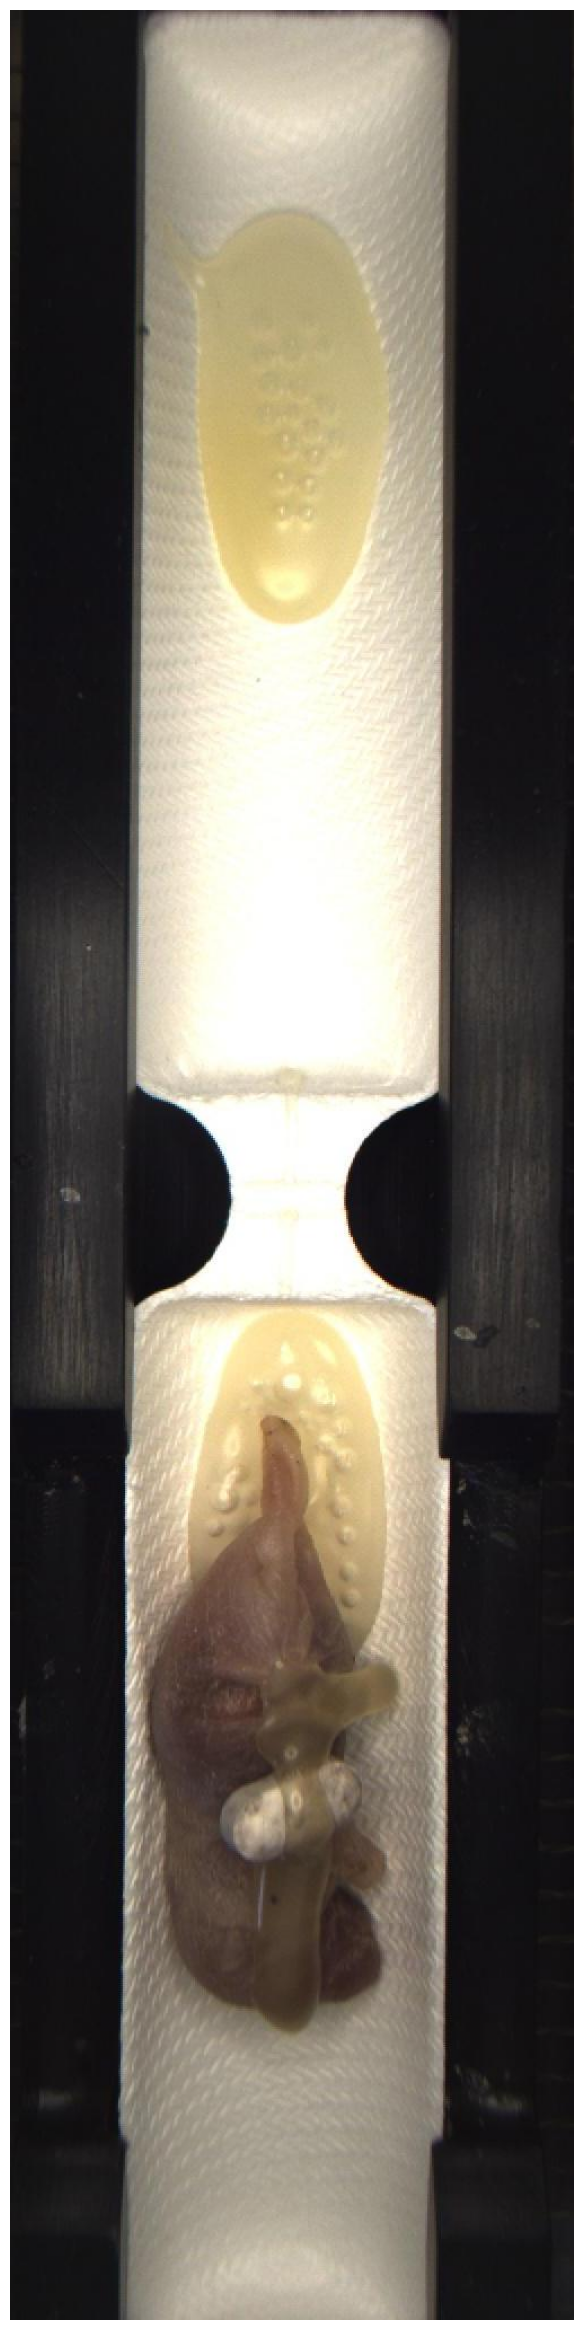

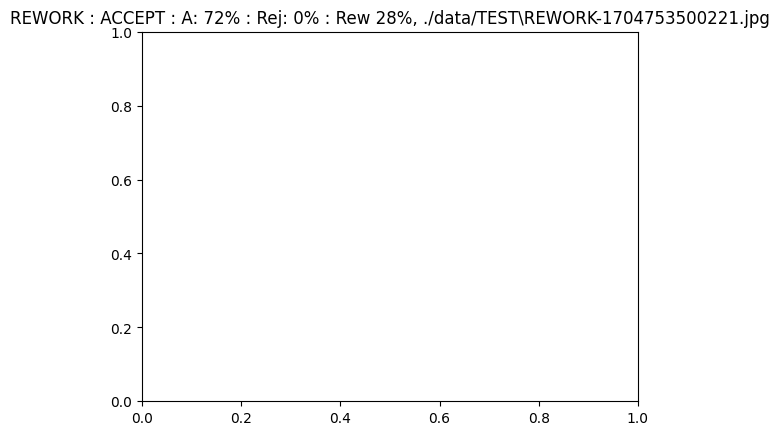

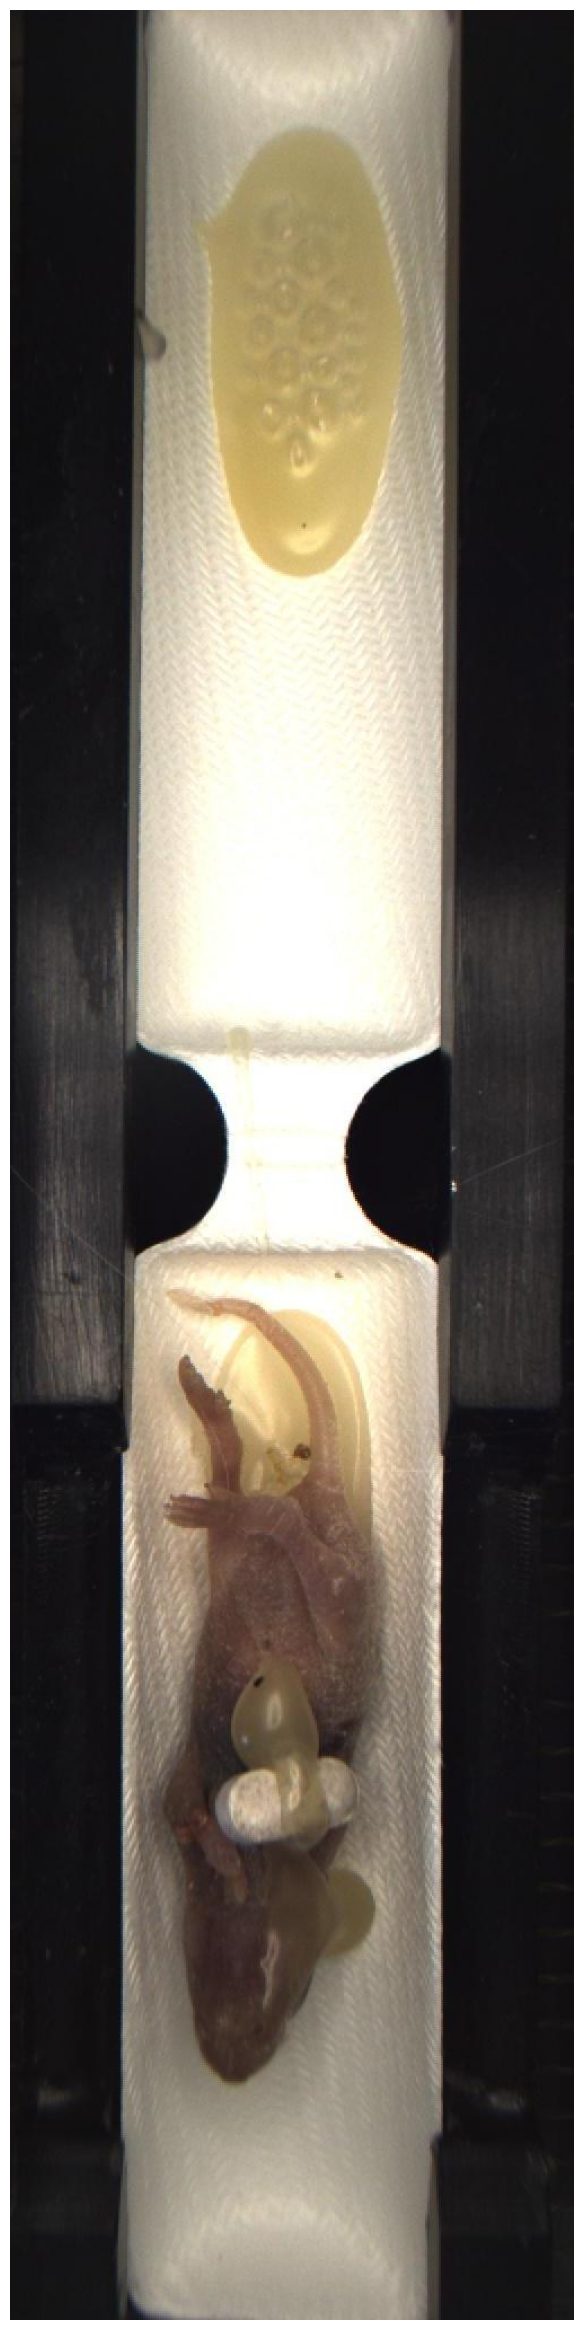

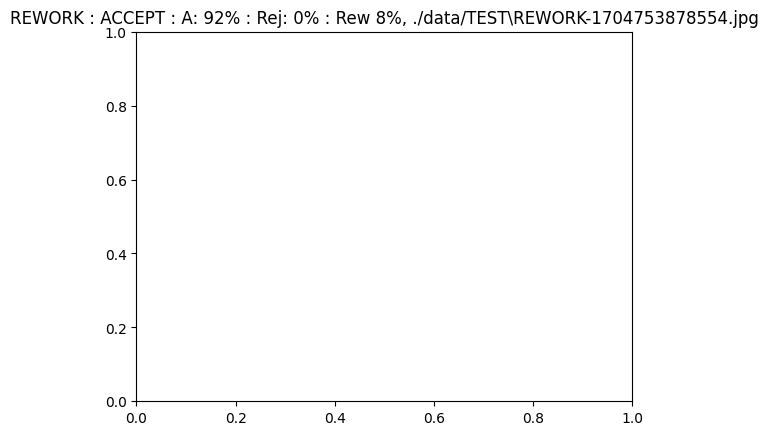

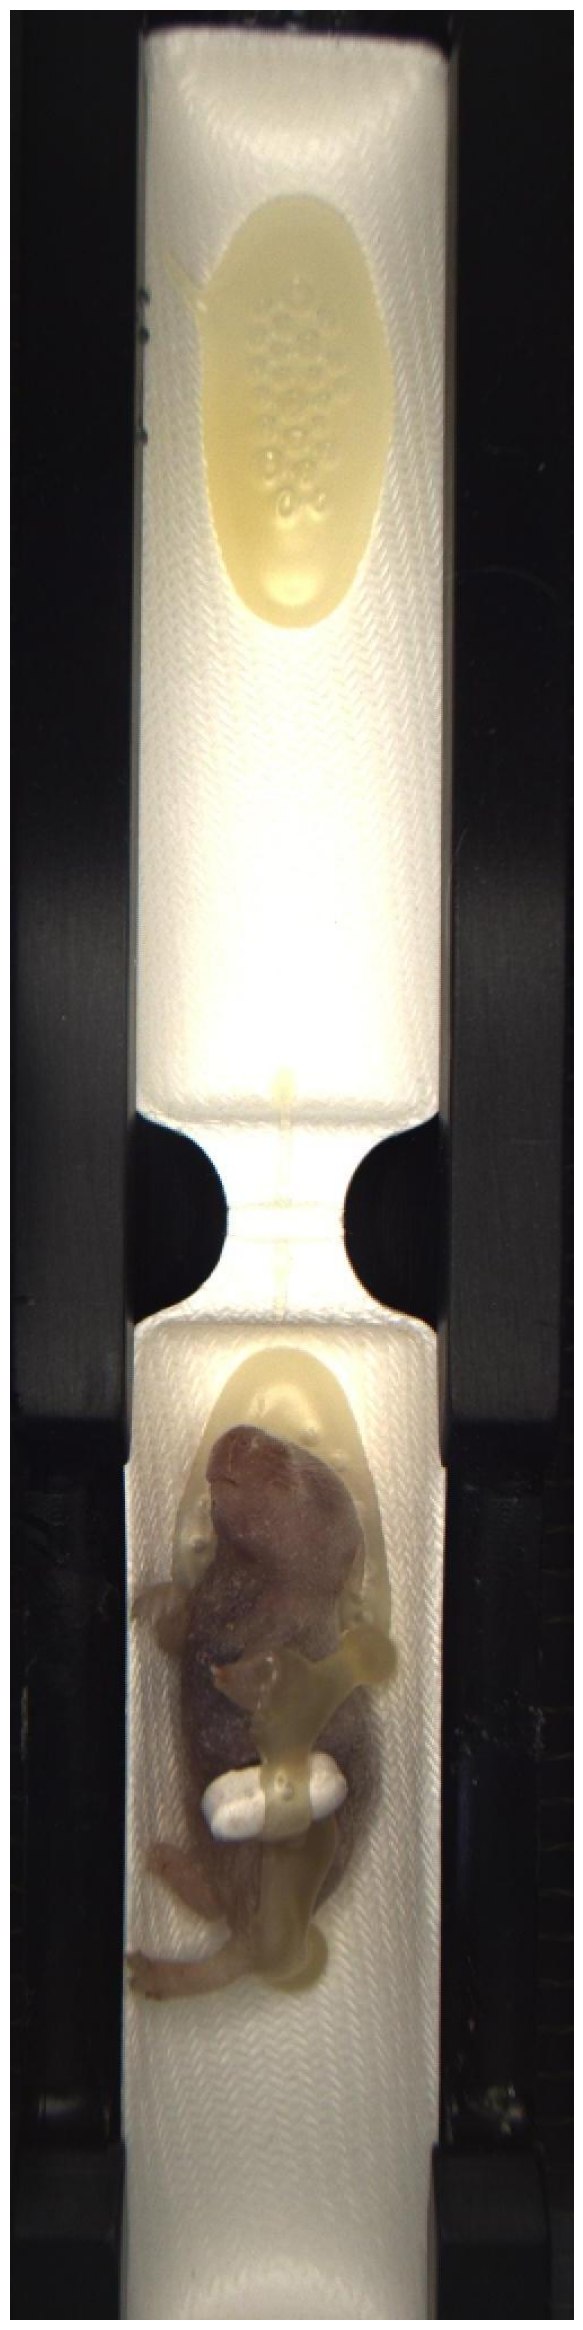

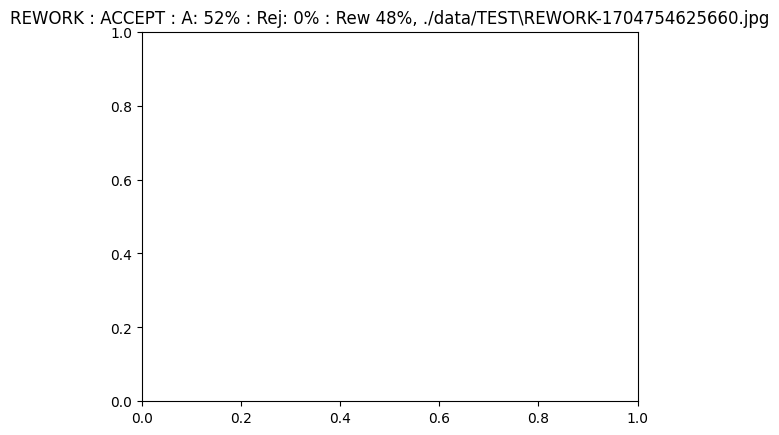

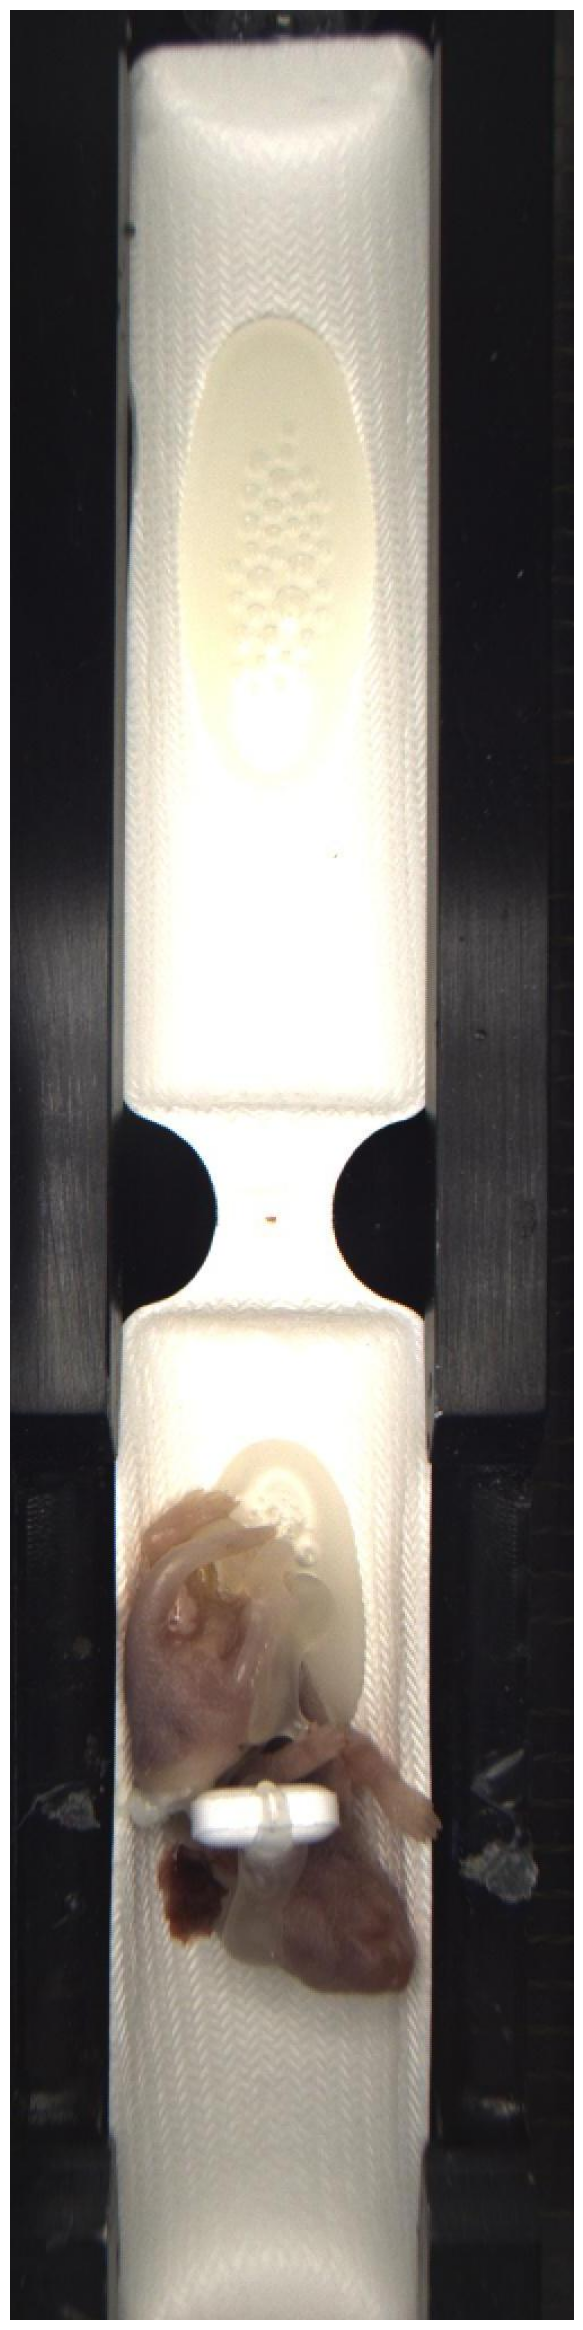

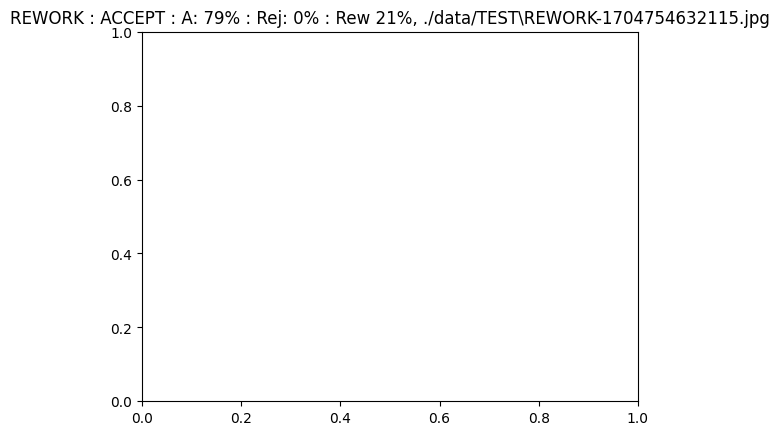

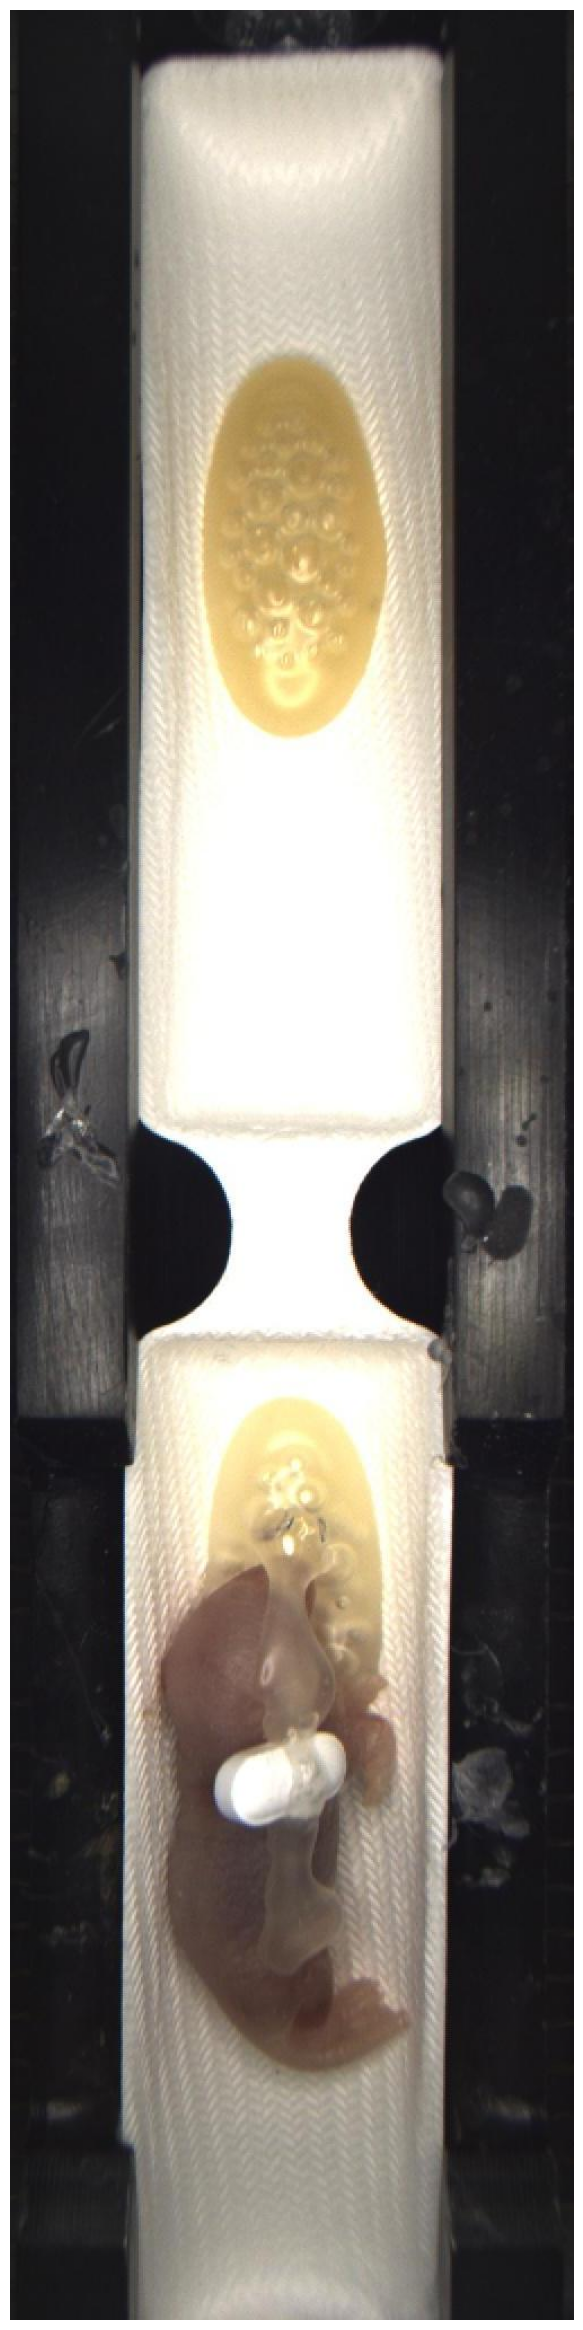

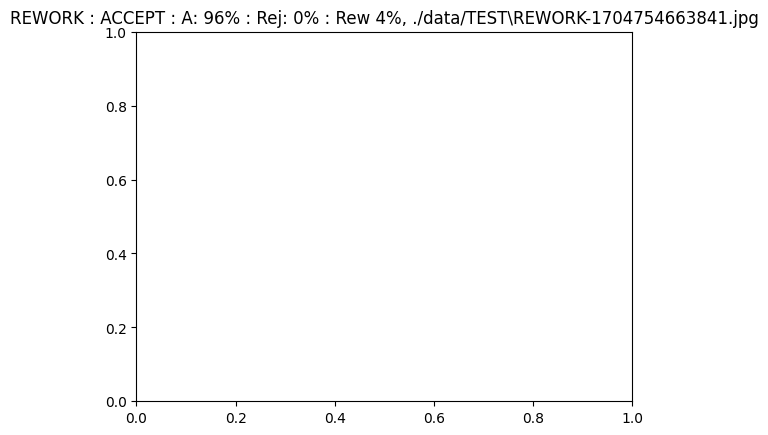

KeyboardInterrupt: 

In [109]:
graph_images("REWORK", misclassified)

In [94]:
graph_images("REJECT", misclassified)

In [69]:
def copy_image(original, destination):
  image_name = original.split("\\")[-1]
  # Open the original image using PIL
  original_image = Image.open(original)
  
  # Create a copy of the image
  image_copy = original_image.copy()
  
  # Specify the path for the copy in the new directory
  new_image_path = os.path.join(destination, image_name)
  
  # Save the copy to the new directory
  image_copy.save(new_image_path)
  
  # Optionally, you can also close the image files
  original_image.close()
  image_copy.close()

In [136]:
loaded_model = tf.keras.models.load_model('./models')

In [5]:
from keras import utils
img_height = int(600 / 8)
img_width = int(2048 / 8)
img = utils.load_img('data/TEST/ACCEPT-1704752034771.jpg', target_size=(img_height, img_width))

img.show()

  
# img_array = image.img_to_array(img)
# img_array = tf.expand_dims(img_array, axis=0)

# prediction = loaded_model.predict(img_array)
# predicted_class = np.argmax(prediction[0])
# predicted_class
